In [1]:
!pip install tensorflow


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera, skew, kurtosis
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# ==== 1. LOAD DATA ====
file_path = "/content/Jaipur.xlsx"  # This will be uploaded by user
df = pd.read_excel(file_path)
df.columns = ['Year', 'Rainfall']
df['Date'] = pd.date_range(start='1980-01-01', periods=len(df), freq='MS')
df.set_index('Date', inplace=True)
df['Rainfall'] = df['Rainfall'].clip(0, 900)
df['Month'] = df.index.month
df['Season'] = df['Month'] % 12 // 3 + 1

# ==== 2. SCALE DATA ====
rain_scaler = MinMaxScaler()
month_scaler = MinMaxScaler()
season_scaler = MinMaxScaler()

rain_scaled = rain_scaler.fit_transform(df[['Rainfall']])
month_scaled = month_scaler.fit_transform(df[['Month']])
season_scaled = season_scaler.fit_transform(df[['Season']])

features = np.hstack([rain_scaled, month_scaled, season_scaled])

# ==== 3. CREATE SLIDING WINDOW ====
def create_dataset(data, look_back=12):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back, 0])
    return np.array(X), np.array(y)

look_back = 12
X, y = create_dataset(features, look_back)

# ==== 4. SPLIT DATA ====
train_size = df.index.get_loc("2011-12-01")
val_size = df.index.get_loc("2020-12-01")

X_train, y_train = X[:train_size+1], y[:train_size+1]
X_val, y_val = X[train_size+1:val_size+1], y[train_size+1:val_size+1]

# ==== 5. BUILD LSTM MODEL ====
model = Sequential([
    Input(shape=(look_back, X.shape[2])),
    LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    callbacks=callbacks,
    verbose=0
)

# ==== 6. PREDICT VALIDATION ====
val_pred = model.predict(X_val, verbose=0).flatten()

# ==== 7. RESIDUAL CORRECTION ====
residuals = y_val - val_pred
gbr = GradientBoostingRegressor(n_estimators=100)
gbr.fit(val_pred.reshape(-1, 1), residuals)
residual_pred = gbr.predict(val_pred.reshape(-1, 1))
val_pred_corrected = val_pred + residual_pred

# ==== 8. INVERSE TRANSFORM ====
y_val_inv = rain_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
val_pred_inv = rain_scaler.inverse_transform(val_pred_corrected.reshape(-1, 1)).flatten()

# ==== 9. FORECAST FUTURE ====
forecast_steps = 60
last_seq = features[-look_back:].copy()
forecast_scaled = []

for _ in range(forecast_steps):
    pred = model.predict(last_seq[np.newaxis], verbose=0).flatten()
    residual = gbr.predict(pred.reshape(-1, 1)).flatten()
    final_pred = pred + residual
    forecast_scaled.append(final_pred[0])
    last_seq = np.roll(last_seq, -1, axis=0)
    last_seq[-1, 0] = final_pred

forecast = rain_scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()
forecast = np.clip(forecast, 0, 900)

# ==== 10. METRICS ====
rmse = np.sqrt(mean_squared_error(y_val_inv, val_pred_inv))
mae = mean_absolute_error(y_val_inv, val_pred_inv)
r2 = r2_score(y_val_inv, val_pred_inv)
ljung = acorr_ljungbox(y_val_inv - val_pred_inv, lags=[10], return_df=True)
jb_stat, jb_pvalue = jarque_bera(y_val_inv - val_pred_inv)
res_skew = skew(y_val_inv - val_pred_inv)
res_kurt = kurtosis(y_val_inv - val_pred_inv)

# ==== 11. EXPORT TO EXCEL ====
val_dates = df.index[train_size+1+look_back:val_size+1+look_back]
forecast_dates = pd.date_range(start='2021-01-01', periods=forecast_steps, freq='MS')

actual_df = pd.DataFrame({'Date': df.index, 'Rainfall': df['Rainfall']})
val_df = pd.DataFrame({'Date': val_dates, 'Observed': y_val_inv, 'Predicted': val_pred_inv})
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecasted_Rainfall': forecast})

output_path = "Jaipur_Rainfall_Forecast_1980_2025.xlsx"
with pd.ExcelWriter("Jaipur_Rainfall_Forecast_1980_2025.xlsx") as writer:
  actual_df.to_excel(writer, sheet_name='Actual Rainfall', index=False)
  val_df.to_excel(writer, sheet_name='Validation', index=False)
  forecast_df.to_excel(writer, sheet_name='Forecast_2021_2025', index=False)

# ==== 12. RETURN OUTPUT PATH ====
output_path


<ipython-input-2-27e3a8a001e0>:100: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_seq[-1, 0] = final_pred
<ipython-input-2-27e3a8a001e0>:100: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_seq[-1, 0] = final_pred
<ipython-input-2-27e3a8a001e0>:100: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_seq[-1, 0] = final_pred
<ipython-input-2-27e3a8a001e0>:100: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error i

'Jaipur_Rainfall_Forecast_1980_2025.xlsx'

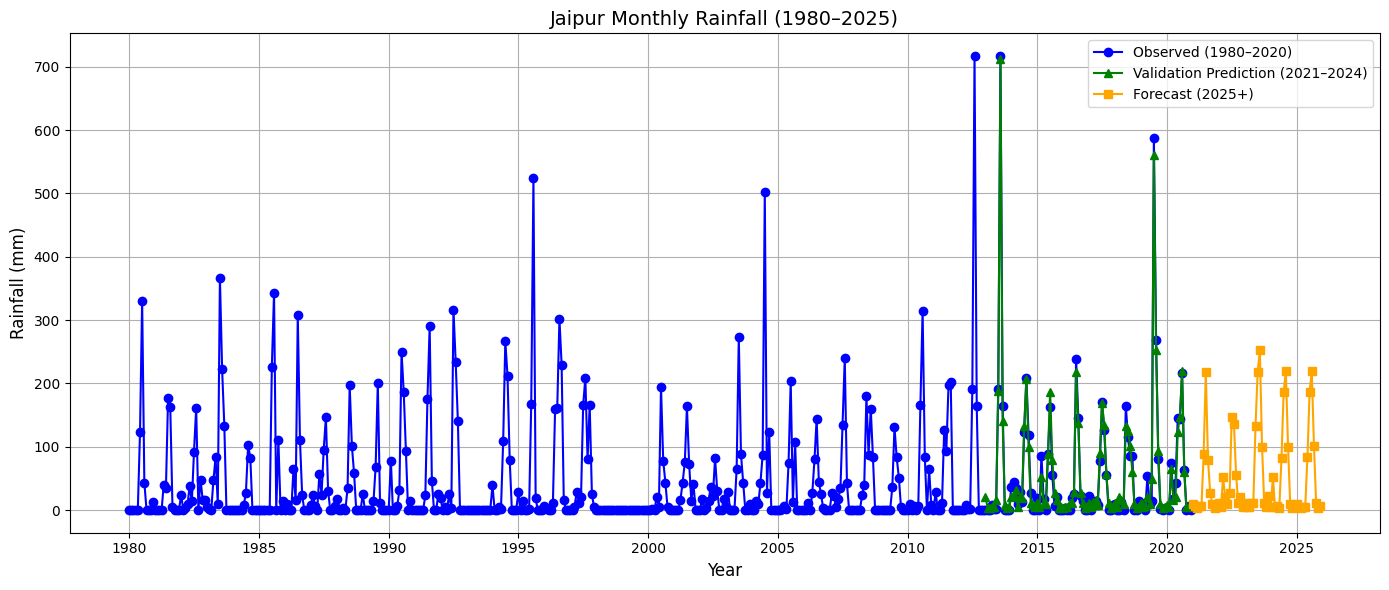


✅ Summary saved to 'Validation_Summary_Jaipur.xlsx'


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera, skew, kurtosis

# Load Excel file and sheets
file_path = "Jaipur_Rainfall_Forecast_1980_2025.xlsx"
actual_df = pd.read_excel(file_path, sheet_name='Actual Rainfall')
val_df = pd.read_excel(file_path, sheet_name='Validation')
forecast_df = pd.read_excel(file_path, sheet_name='Forecast_2021_2025')

# Ensure Date columns are datetime
actual_df['Date'] = pd.to_datetime(actual_df['Date'])
val_df['Date'] = pd.to_datetime(val_df['Date'])
forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])

# ---- 📈 PLOT ALL ----
plt.figure(figsize=(14, 6))

plt.plot(actual_df['Date'], actual_df['Rainfall'], label='Observed (1980–2020)', color='blue', marker='o')
plt.plot(val_df['Date'], val_df['Predicted'], label='Validation Prediction (2021–2024)', color='green', marker='^')
plt.plot(forecast_df['Date'], forecast_df['Forecasted_Rainfall'], label='Forecast (2025+)', color='orange', marker='s')

plt.title("Jaipur Monthly Rainfall (1980–2025)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Rainfall (mm)", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Rainfall_Full_Trend_Jaipur.png", dpi=300)
plt.show()

# ---- 📊 METRICS CALCULATION ----

# Extract actual and predicted values for validation
y_true = val_df['Observed'].values
y_pred = val_df['Predicted'].values
residuals = y_true - y_pred

# Basic metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Residual tests
ljung_box = acorr_ljungbox(residuals, lags=[10], return_df=True)
jb_stat, jb_pvalue = jarque_bera(residuals)
residual_skew = skew(residuals)
residual_kurt = kurtosis(residuals)

# ---- 📄 SAVE SUMMARY TO EXCEL ----

summary = pd.DataFrame({
    'Metric': [
        'RMSE', 'MAE', 'R-squared',
        'Ljung-Box Q (lag=10)', 'Ljung-Box p-value',
        'Jarque-Bera Statistic', 'Jarque-Bera p-value',
        'Residual Skewness', 'Residual Kurtosis'
    ],
    'Value': [
        rmse, mae, r2,
        ljung_box['lb_stat'].iloc[0], ljung_box['lb_pvalue'].iloc[0],
        jb_stat, jb_pvalue,
        residual_skew, residual_kurt
    ]
})

summary_path = "Validation_Summary_Jaipur.xlsx"
summary.to_excel(summary_path, index=False)

print(f"\n✅ Summary saved to '{summary_path}'")


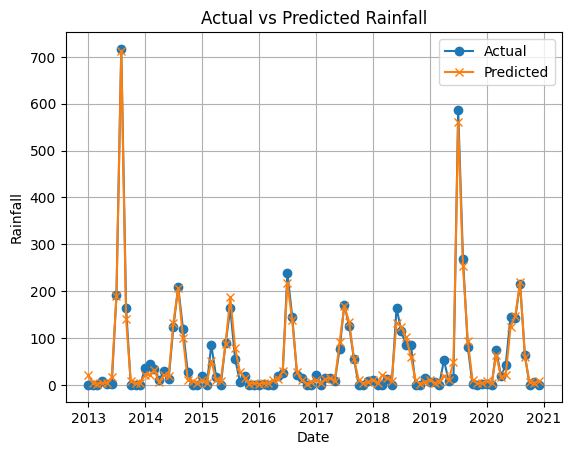

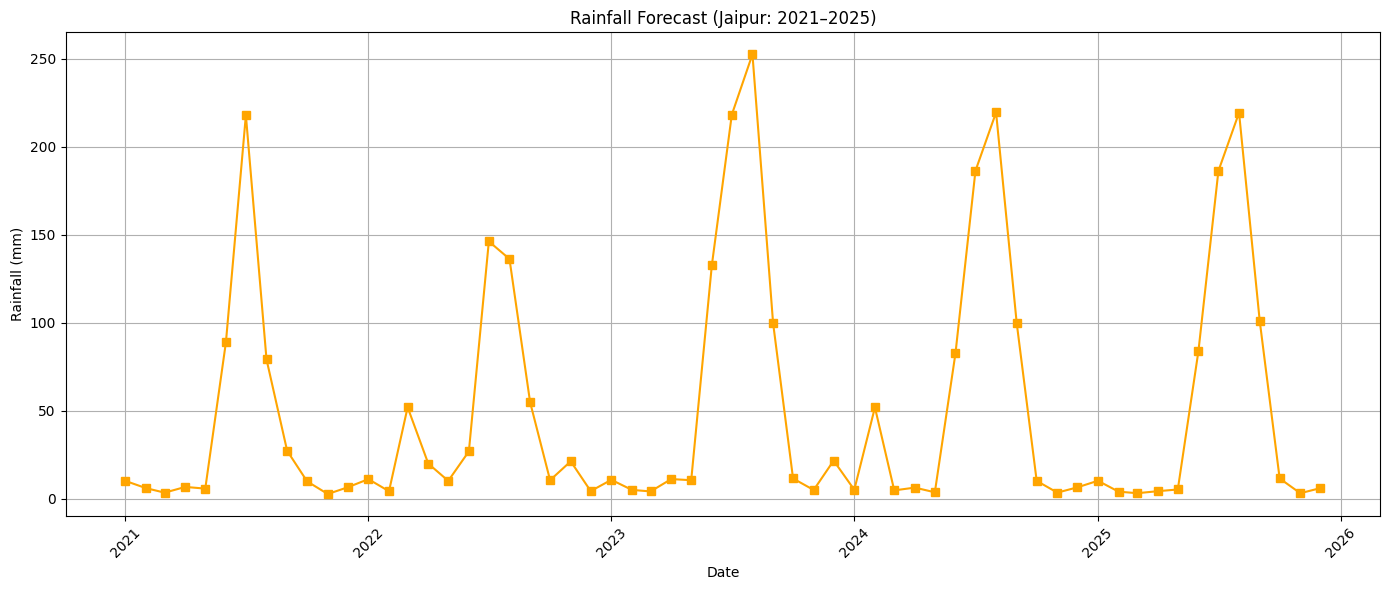

(                     Metric      Value
 0                      RMSE  12.508976
 1                       MAE   9.174600
 2                 R-squared   0.986576
 3      Ljung-Box Q (lag=10)   7.770958
 4         Ljung-Box p-value   0.651198
 5     Jarque-Bera Statistic   8.246147
 6       Jarque-Bera p-value   0.016195
 7         Residual Skewness   0.587458
 8         Residual Kurtosis   0.825293
 MAE                  9.1746   9.174600
 RMSE              12.508976  12.508976
 R2                 0.986576   0.986576,
 '/mnt/data/Validation_Summary_Jaipur.xlsx',
 '/mnt/data/Validation_Plot_Jaipur.png',
 '/mnt/data/Forecast_Plot_Jaipur.png')

<Figure size 640x480 with 0 Axes>

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the generated Excel file
file_path = "Jaipur_Rainfall_Forecast_1980_2025.xlsx"
actual_df = pd.read_excel(file_path, sheet_name='Actual Rainfall')
val_df = pd.read_excel(file_path, sheet_name='Validation')
forecast_df = pd.read_excel(file_path, sheet_name='Forecast_2021_2025')

plt.plot(val_df['Date'], val_df['Observed'], label='Actual', marker='o')
plt.plot(val_df['Date'], val_df['Predicted'], label='Predicted', marker='x')
plt.xlabel('Date')
plt.ylabel('Rainfall')
plt.title('Actual vs Predicted Rainfall')
plt.legend()
plt.grid(True)
plt.show()


# Plot forecast
plt.figure(figsize=(14, 6))
plt.plot(forecast_df['Date'], forecast_df['Forecasted_Rainfall'], label='Forecast', color='orange', marker='s')
plt.title('Rainfall Forecast (Jaipur: 2021–2025)')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Forecast_Plot_Jaipur.png", dpi=300)
plt.show()

import os
output_dir = "/mnt/data"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

plt.savefig(os.path.join(output_dir, "Forecast_Plot_Jaipur.png"), dpi=300)


# Summary statistics for validation
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Mean Absolute Error
summary.loc['MAE'] = abs(val_df['Observed'] - val_df['Predicted']).mean()

# Root Mean Squared Error
summary.loc['RMSE'] = np.sqrt(mean_squared_error(val_df['Observed'], val_df['Predicted']))

# R-squared
summary.loc['R2'] = r2_score(val_df['Observed'], val_df['Predicted'])


summary_path = "/mnt/data/Validation_Summary_Jaipur.xlsx"
summary.to_excel(summary_path)

summary, summary_path, "/mnt/data/Validation_Plot_Jaipur.png", "/mnt/data/Forecast_Plot_Jaipur.png"
